## Classical Algorithms for Vectorization

In this notebook we are using classical algorithms as KAZE and SURF for generating feature-vector representation for image signatures. In order to measure semilarety between images, we compute Euclidian distance between corresponding vectors.

We are using a data set with 10019 triplets. Each triplet is maded for a anchor, a positive and a negative image signature. 

In [1]:
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

print( "cv2 version:", cv2.__version__ )

cv2 version: 3.4.2


**Loading images**

In [3]:
sample_signatures_df = pd.read_csv( '../dataset/signatures/X_test.csv' )
print(sample_signatures_df.shape)
sample_signatures_df.head()

(10019, 3)


,Anchor,Positive,Negative
0,original_45_3.png,original_45_19.png,forgeries_45_19.png
1,original_37_18.png,original_37_15.png,forgeries_37_15.png
2,original_24_11.png,original_24_24.png,forgeries_24_24.png
3,original_33_20.png,original_33_3.png,forgeries_33_3.png
4,original_2_9.png,original_2_22.png,forgeries_2_22.png


**Method for processing input image**

In [4]:
def processing_image( image_path ):
    
    # Read image as grayscale
    image = cv2.imread( image_path, cv2.IMREAD_GRAYSCALE )
    
    # Binarize image through Otsu's thresholding. 
    # Background will be back and signature will be white.
    _, image_bin = cv2.threshold( image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU )
    
    return image_bin

**Methods for computing distance**

In [5]:
def cosine_distances( u, v ):
    from sklearn.metrics.pairwise import cosine_distances
    return cosine_distances( u, v )

In [6]:
def euclidean_distances( u, v ):
    from sklearn.metrics.pairwise import euclidean_distances
    return euclidean_distances( u, v )

### KAZE descriptor   
Reference: https://medium.com/machine-learning-world/feature-extraction-and-similar-image-search-with-opencv-for-newbies-3c59796bf774

In [7]:
def extract_features_KAZE( image, vector_size = 32 ):
    
    alg = cv2.KAZE_create()
    
    # Dinding image keypoints
    kps = alg.detect(image)
    
    # Getting first 32 of them. 
    # Number of keypoints is varies depend on image size and color pallet
    # Sorting them based on keypoint response value(bigger is better)
    kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
    
    # computing descriptors vector
    kps, dsc = alg.compute(image, kps)
    
    # Flatten all of them in one big vector - our feature vector
    dsc = dsc.flatten()
    
    # Making descriptor of same size
    # Descriptor vector size is 64
    needed_size = (vector_size * 64)
    if dsc.size < needed_size:
        # if we have less the 32 descriptors then just adding zeros at the
        # end of our feature vector
        dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
        
    return dsc 

### SURF descriptor   

References:
* https://stackoverflow.com/questions/52305578/sift-cv2-xfeatures2d-sift-create-not-working-even-though-have-contrib-instal
* https://docs.opencv.org/3.4.3/d5/dde/tutorial_feature_description.html 
* https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_surf_intro/py_surf_intro.html#surf

In [8]:
def extract_features_SURF( image, minHessian = 400):
        
    # Detect the keypoints using SURF Detector, compute the descriptors
    detector = cv2.xfeatures2d_SURF.create( hessianThreshold = minHessian )
    keypoints, descriptors = detector.detectAndCompute(image, None)    
    
    if descriptors.all() == None:
        return None
        
    return descriptors.flatten()

### Testing descriptors

In [9]:
results_df = pd.DataFrame( columns = ['Anchor', 'Positive', 'Negative', 
                                      'Pos-SURF-Dist', 'Neg-SURF-Dist', 
                                      'Pos-Kaze-Dist', 'Neg-Kaze-Dist'] )

genuine_signatures_path =  "../dataset/signatures/full_org/"
forged_signatures_path = "../dataset/signatures/full_forg/"

for index, row in tqdm( sample_signatures_df.iterrows() ): 
    
    anchor   = processing_image( genuine_signatures_path + row["Anchor"]   )
    positive = processing_image( genuine_signatures_path + row["Positive"] )
    negative = processing_image( forged_signatures_path  + row["Negative"] )
           
    # --- KAZE descriptor ---
    anchor_kaze_dsc = extract_features_KAZE( anchor )
    positive_kaze_dsc = extract_features_KAZE( positive )
    negative_kaze_dsc = extract_features_KAZE( negative )

    pos_kaze_dist = euclidean_distances( [anchor_kaze_dsc], [positive_kaze_dsc] )
    neg_kaze_dist = euclidean_distances( [anchor_kaze_dsc], [negative_kaze_dsc] )

    # --- SURF descriptor ---
    anchor_surf_dsc = extract_features_SURF( anchor )
    positive_surf_dsc = extract_features_SURF( positive )
    negative_surf_dsc = extract_features_SURF( negative )

    pos_surf_dist = -1
    neg_surf_dist = -1

    if positive_surf_dsc.all() != None and negative_surf_dsc.all() != None:

        size = max(anchor_surf_dsc.size, positive_surf_dsc.size, negative_surf_dsc.size)

        # Making feature vectors of same size
        if anchor_surf_dsc.size < size:
            anchor_surf_dsc = np.concatenate([anchor_surf_dsc, np.zeros(size - anchor_surf_dsc.size)])

        if positive_surf_dsc.size < size:
            positive_surf_dsc = np.concatenate([positive_surf_dsc, np.zeros(size - positive_surf_dsc.size)])

        if negative_surf_dsc.size < size:
            negative_surf_dsc = np.concatenate([negative_surf_dsc, np.zeros(size - negative_surf_dsc.size)])

        pos_surf_dist = euclidean_distances( [anchor_surf_dsc], [positive_surf_dsc] )
        neg_surf_dist = euclidean_distances( [anchor_surf_dsc], [negative_surf_dsc] )

    # Saving distances on pandas dataframe
    results_df = results_df.append( {'Anchor' : row["Anchor"], 
                                     'Positive' : row["Positive"], 
                                     'Negative' : row["Negative"], 
                                     'Pos-SURF-Dist' : pos_surf_dist[0][0], 
                                     'Neg-SURF-Dist' : neg_surf_dist[0][0], 
                                     'Pos-Kaze-Dist' : pos_kaze_dist[0][0], 
                                     'Neg-Kaze-Dist' : neg_kaze_dist[0][0]
                                     }, ignore_index=True )

10019it [3:57:13,  1.52s/it]


In [10]:
results_df.head()

,Anchor,Positive,Negative,Pos-SURF-Dist,Neg-SURF-Dist,Pos-Kaze-Dist,Neg-Kaze-Dist
0,original_45_3.png,original_45_19.png,forgeries_45_19.png,16.244788,19.495871,4.332119,4.180222
1,original_37_18.png,original_37_15.png,forgeries_37_15.png,18.057001,17.151524,3.794681,3.613640
2,original_24_11.png,original_24_24.png,forgeries_24_24.png,14.787510,19.244377,4.685726,4.694830
3,original_33_20.png,original_33_3.png,forgeries_33_3.png,14.997617,31.841983,4.338669,4.311652
4,original_2_9.png,original_2_22.png,forgeries_2_22.png,20.292387,22.006924,4.373150,4.437897


In [11]:
results_df.describe()

,Pos-SURF-Dist,Neg-SURF-Dist,Pos-Kaze-Dist,Neg-Kaze-Dist
count,10019.000000,10019.000000,10019.000000,10019.000000
mean,19.594372,22.660725,4.290112,4.333114
std,4.363164,5.393417,0.247175,0.226544
min,9.624640,10.022026,1.607622,3.410800
25%,16.414996,18.879736,4.129354,4.186413
50%,19.574543,22.168287,4.294860,4.336952
75%,22.546072,26.023236,4.457046,4.490592
max,34.647639,40.124608,5.211287,5.244497


In [12]:
results_df.to_csv( 'signature_similarity_surf_kaze.csv', index=False)

In [13]:
results_df = results_df.round(0)
results_df.head()

,Anchor,Positive,Negative,Pos-SURF-Dist,Neg-SURF-Dist,Pos-Kaze-Dist,Neg-Kaze-Dist
0,original_45_3.png,original_45_19.png,forgeries_45_19.png,16.0,19.0,4.0,4.0
1,original_37_18.png,original_37_15.png,forgeries_37_15.png,18.0,17.0,4.0,4.0
2,original_24_11.png,original_24_24.png,forgeries_24_24.png,15.0,19.0,5.0,5.0
3,original_33_20.png,original_33_3.png,forgeries_33_3.png,15.0,32.0,4.0,4.0
4,original_2_9.png,original_2_22.png,forgeries_2_22.png,20.0,22.0,4.0,4.0


In [15]:
results_surf_kaze = results_df.drop( columns = ['Anchor', 'Positive', 'Negative'] )

In [16]:
results_surf_kaze.head()

,Pos-SURF-Dist,Neg-SURF-Dist,Pos-Kaze-Dist,Neg-Kaze-Dist
0,16.0,19.0,4.0,4.0
1,18.0,17.0,4.0,4.0
2,15.0,19.0,5.0,5.0
3,15.0,32.0,4.0,4.0
4,20.0,22.0,4.0,4.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000198463BE4A8>,
      dtype=object)

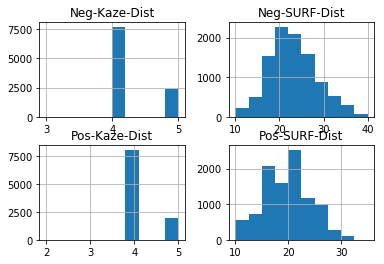

In [17]:
results_surf_kaze.hist()

In [18]:
results_surf_kaze.describe()

,Pos-SURF-Dist,Neg-SURF-Dist,Pos-Kaze-Dist,Neg-Kaze-Dist
count,10019.000000,10019.000000,10019.000000,10019.000000
mean,19.598064,22.661842,4.195728,4.235353
std,4.372280,5.400161,0.398287,0.424711
min,10.000000,10.000000,2.000000,3.000000
25%,16.000000,19.000000,4.000000,4.000000
50%,20.000000,22.000000,4.000000,4.000000
75%,23.000000,26.000000,4.000000,4.000000
max,35.000000,40.000000,5.000000,5.000000
